In [2]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_colwidth', -1)

In [3]:
data_root = pathlib.Path('./input')

In [4]:
train_path = './input/train.csv/train.csv'
test_path = './input/test.csv/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
# train_df = train_df.drop(['qid'], axis=1)
# test_df = test_df.drop(['qid'], axis=1)

In [5]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [6]:
# To see what insincere question looks like
train_df.where(train_df.target == 1).dropna().sample(10)

,qid,question_text,target
895386,af6c68985f6531308aa5,Would it be legal for Trump to order soldiers to shoot undocumented immigrants?,1.0
908402,b1ff7c81869c86f3a904,Is Elon Musk a man or a woman?,1.0
522783,6657d77c6b8861eeada2,Do Hindus who have converted to Islam eat beef?,1.0
191145,255f0a44c4204122faf2,Why aren't women/ girls hot?,1.0
503804,62a5382b75d1c6cd7a9f,Why are men so controlling?,1.0
1086968,d50134a3af5b0aaa1a58,"Is Bernie Sanders only pretending to be a Jew so as to appeal to Millennials, who mostly hate white Christians?",1.0
559342,6d974dd03a9eb0808e0e,"White people shouldn't even exist, don't you think?",1.0
235049,2dfbe6d042d66591514a,Why Dutch men afraid of intelligent female?,1.0
879007,ac37511755309145a987,Why do the black genes will be more powerful?,1.0
917905,b3de5a5dd5888d8ae5aa,Why do you think girls always falls for bad guys and ignore the good guys?,1.0


In [7]:
# To see what sincere question looks like
train_df.where(train_df.target == 0).dropna().sample(10)

,qid,question_text,target
809448,9e9ffced5ad23791d7e5,Why do light bulbs connected in parallel shorten the battery life?,0.0
904017,b124fa276f5192a46147,"How much money annually does Quora contribute to the Clinton Foundation, in exchange for a manipulated liberal bias?",0.0
236337,2e3be02c71956549e6a9,What is the current state of the UK economy?,0.0
269945,34d7c8daff94129df444,How do I get out of soft drink?,0.0
715931,8c25ffaa6c6ea72a8749,Why was the Unites States referred to as a sleeping giant and is it still considered one today?,0.0
675080,8435a90b13075fbc9594,How nice is Sylhet?,0.0
544241,6a9fca14b378e9288161,How do I understand and be safe from electronic/electrical witchcraft?,0.0
1168438,e4f65153320499610fcb,What rank can I expect in WBJEE with a score of about 70/200?,0.0
108848,154fc6f4334e77451b23,What is the difference between Radiotheraphy technology and Radiology and imaging technology?,0.0
536572,6919b1a3061ff229393d,"When you get married in Germany, can you change your middle name to your maiden name?",0.0


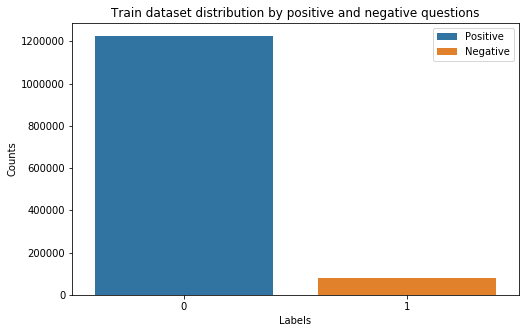

In [8]:
def plot_dist(data=train_df, data_type='Train'):
    fig = plt.figure(figsize=(8,5))
    uniques = data.target.unique()
    counts = data.target.value_counts()
    ax = sns.barplot(x=uniques,y=counts, dodge=False, hue=['0','1'])

    ax.set(xlabel='Labels')
    ax.set(ylabel='Counts')
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["Positive", "Negative"])
    plt.title(data_type + ' dataset distribution by positive and negative questions')
    plt.show()
    
plot_dist(train_df)

In [9]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])

def tweet_clean(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text) # remove the line breaker in each question
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text

def tokenizer(s):
    return nlp(tweet_clean(s))

In [10]:
# sample_df = train_df.question_text[0:10]
# sample_df = sample_df.progress_apply(lambda x: tweet_clean(x))
# print(sample_df)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


0    how did quebec nationalists see their province as a nation in the 1960s                                                                                                                                                                             
1    do you have an adopted dog how would you encourage people to adopt and not shop                                                                                                                                                                     
2    why does velocity affect time does velocity affect space geometry                                                                                                                                                                                   
3    how did otto von guericke used the magdeburg hemispheres                                                                                                                                                                                            


In [11]:
train_df['question_text'] = train_df.question_text.progress_apply(lambda x: tweet_clean(x))

Progress: 100%|███████████████████████████████████████████████████| 1306122/1306122 [00:24<00:00, 53515.24it/s]


In [12]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,how did quebec nationalists see their province as a nation in the 1960s,0
1,000032939017120e6e44,do you have an adopted dog how would you encourage people to adopt and not shop,0
2,0000412ca6e4628ce2cf,why does velocity affect time does velocity affect space geometry,0
3,000042bf85aa498cd78e,how did otto von guericke used the magdeburg hemispheres,0
4,0000455dfa3e01eae3af,can i convert montra helicon d to a mountain bike by just changing the tyres,0


In [13]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [14]:
traindf, valdf = split_train_test(train_df, test_size=0.2)

In [15]:
traindf.shape
valdf.shape

(1044897, 3)

(261225, 3)

In [16]:
# Store the dataframe into csv to read later as TabularDataset
traindf.to_csv(data_root/'traindf.csv', index=False)
valdf.to_csv(data_root/'valdf.csv', index=False)

In [17]:
train_df['question_text'][0]

'how did quebec nationalists see their province as a nation in the 1960s '

## DATA CLEANING

In [18]:
def splitter(x): return x.split()

In [19]:
TEXT = data.Field(sequential=True, tokenize=splitter, include_lengths=True, use_vocab=True)
LABEL = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_fields = [
    ('qid', None),
    ('question_text', TEXT),
    ('target', LABEL)
]

In [20]:
%%time
trainds, valds = data.TabularDataset.splits(path='./input/', format='csv', 
                                            train='traindf.csv', validation='valdf.csv', 
                                            fields=train_fields, skip_header=True)

Wall time: 20.6 s


In [21]:
len(trainds)

1044897

In [22]:
ex = trainds.examples[0]
trainds.fields.items()
ex.target
ex.question_text

dict_items([('qid', None), ('question_text', <torchtext.data.field.Field object at 0x0000015186823AC8>), ('target', <torchtext.data.field.Field object at 0x0000015186823940>)])

'0'

['how',
 'is',
 'strategic',
 'positioning',
 'is',
 'different',
 'from',
 'marketing',
 'positioning']

In [23]:
%%time
vec = vocab.Vectors('word2vec.txt', './input/')

Wall time: 328 ms


In [24]:
len(vec.vectors)

258110

In [25]:
%%time
TEXT.build_vocab(trainds, valds, max_size=258110, vectors=vec)
LABEL.build_vocab(trainds)

Wall time: 17.8 s


In [26]:
TEXT.vocab.vectors.shape

torch.Size([192520, 50])

In [27]:
TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

tensor([-1.5454, -0.3855, -1.3414, -0.1820,  0.9111, -0.0511,  2.3909,  0.0982,
        -1.2502,  2.0930,  0.4491,  2.8606, -0.1207, -0.8120, -1.3948, -2.5018,
        -0.8181,  0.5812,  4.7760,  0.1531, -1.6925,  1.2428, -0.4360,  0.9675,
         1.3102,  0.2022,  1.0768, -0.2839, -2.1971, -0.6728,  1.5275,  3.3601,
         2.2180, -0.0426, -0.4355, -0.2776,  1.4450, -0.6309,  0.7143, -0.4283,
         0.4671,  1.4224, -3.1848,  0.8012,  3.7483, -1.3917, -1.5730, -1.9213,
         1.7973, -3.2339])

In [28]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.question_text), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [29]:
len(traindl), len(valdl)

(348299, 87075)

In [30]:
batch = next(iter(traindl))

batch.question_text

(tensor([[    3,    32,    32],
         [    4,   786,     4],
         [    2,   282,    56],
         [ 1963,  4165,     6],
         [  795,    24,   376],
         [    8,  9367,     7],
         [  238,   252, 18906],
         [  333,  2776,     5],
         [   23,    61,   869],
         [  215,  2429,     8],
         [   23,    30,   111],
         [    2,   253,   471],
         [  800,   846,    24],
         [    8,  1171,  4020],
         [ 2388,   244, 26901],
         [    7,     2,    18],
         [  241,    63,   206],
         [ 1301,     1,     1]]), tensor([18, 17, 17]))